In [603]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from gym import spaces
import math

In [ ]:
G = 6.6743e-11 # N m2 kg-2
EARTH_M_KG = 5.9722e24 # kg
EARTH_R_KM = 6.378137e3 # km WGS84 semi-major axis
EARTH_R_M = 6.378137e6 # m WGS84 semi-major axis
g = 9.802 # m s-2



# return the value of the acceleration due to gravity of EARTH 
# at specified altitude in km
EARTH_R_KM_INVERSE = 1/EARTH_R_KM
def calc_gravity(height_above_earth_km):
    return g/(1 + height_above_earth_km*EARTH_R_KM_INVERSE)**2

def drag_deceleration(height_above_earth_km, orbital_velocity_kms, mass_kg, drag_coeff, drag_area):
    return 0.5**drag_coeff*(orbital_velocity_kms**2)*drag_area / mass_kg

def physics_step(curr_pos, curr_vel):
    curr_alt = np.linalg.norm(curr_pos)
    curr_theta = np.arctan2(curr_pos[1], curr_pos[0])
    
    grav = calc_gravity(curr_alt)
    
    a = grav*np.array([np.cos(curr_theta), np.sin(curr_theta)]) # - dec*np.array([np.cos()])
    v = curr_vel + a*dt
    x = curr_pos + v*dt
    
    return v, x

In [641]:
G = 6.6743e-11 # N m2 kg-2

class OrbitSimEnv(gym.Env):
    
    def __init__(self, random_distance=False, random_angle=False, random_distance_min_max=[15, 30]):
        self._random_distance = random_distance
        self._random_angle = random_angle
        self._random_dist_minmax = random_distance_min_max
        
        # "Earth" object properties
        self.EARTH_MASS = 9.8e10
        self.EARTH_POS = np.array([0,0])
        
        # "Spacecraft, sc" object state
        self._SC_MASS = 1
        self._sc_init_pos = 2
        self._sc_init_vel = 1.808
        self._sc_init_delta_v = 10.0
        
        self._reset()
        self.calc_pos()
        self.calc_vel()
        
#         self._sc_pos_mag = np.linalg.norm(self._sc_pos)
#         self._sc_pos_angle = np.arctan2(self._sc_pos[1], self._sc_pos[0])
#         self._sc_vel_mag = np.linalg.norm(self._sc_vel)
#         self._sc_vel_angle = np.arctan2(self._sc_vel[1], self._sc_vel[0])
        
        self.dt = 0.01 # step size
        
        # actions: do nothing, fire 0.01, fire 0.1
        self.action_space = spaces.Discrete(2)
        self._action_to_impulse = {
            0: 0,
            1: 0.01,
            #2: 0.1
        }
        
        
        # end when distance is <1 or >5, when delta_v is 0
        
        # rewards +1 for living each time step
        # -1000 for hitting earth or leaving
        # -(abs(distance - 2))
        # + delta_v remaining
        
    def _get_obs(self):
        return np.array([self._sc_pos_mag, self._sc_vel_mag, self._sc_vel_angle]) # self._sc_delta_v self._sc_vel_angleself._sc_vel_mag,self._sc_delta_v, self._sc_vel_mag, self._sc_vel_angle,
    
    def _get_info(self):
        return None
    
    def get_state(self):
        return self._sc_pos, self._sc_vel, self._sc_delta_v
    
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        
        self._reset()
        
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, info
    
    def _calc_init_pos_vel(self):
        self._sc_init_pos = 0.1*np.random.randint(self._random_dist_minmax[0],self._random_dist_minmax[1])
        self._sc_init_vel = np.sqrt(G*self.EARTH_MASS / self._sc_init_pos)
        
    def _reset(self):
        # random starting angle
        if self._random_angle:
            angle = np.random.rand()*np.pi*2
        else:
            angle = 0
            
        if self._random_distance:
            self._calc_init_pos_vel()
            
        #self._sc_init_delta_v = 1.0*np.random.randint(1, 10)
        self._sc_pos = self._sc_init_pos*np.array([np.cos(angle), np.sin(angle)])
        self._sc_vel = self._sc_init_vel*np.array([-np.sin(angle), np.cos(angle)])
        self._sc_delta_v = self._sc_init_delta_v
        
    def is_fuel_empty(self):
        return self._sc_delta_v <= 0.0
        
    def step(self, action):
        # impulse can only happen if we have fuel remaining
        if (not self.is_fuel_empty()):
            delta_v = self._action_to_impulse[action]
            self._sc_delta_v -= delta_v
            self._sc_vel += delta_v*(np.array(-self._sc_pos[1], self._sc_pos[0])/self._sc_pos_mag)

        grav = self.calc_grav()
        drag = self.calc_drag()
        a = grav + drag
        
        self._sc_vel += a*self.dt
        self._sc_pos += self._sc_vel*self.dt
        
        self.calc_pos()
        self.calc_vel()
        
        reward = 0.0
        done = False
        
        if self._sc_pos_mag < 1 or self._sc_pos_mag > 5:
            done = True
            reward = -657 # penalty for hitting earth/boundry
        else:
            reward += 1 # for living
            #reward -= abs(self._sc_pos_mag - self._sc_init_pos)**2 # pentaly for diviating from circulor orbit
            #reward += self._sc_delta_v # reward for conserving delta_v
            
            #         elif self._sc_delta_v <= 0:
#             done = True
#             reward = -200 # pentaly for running out of fuel
        
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, reward, done, False, info
    
    def calc_pos(self):
        self._sc_pos_mag = np.linalg.norm(self._sc_pos)
        self._sc_pos_angle = np.arctan2(self._sc_pos[1], self._sc_pos[0])
        
    def calc_vel(self):
        self._sc_vel_mag = np.linalg.norm(self._sc_vel)
        self._sc_vel_angle = np.arctan2(self._sc_vel[1], self._sc_vel[0])
        
    def calc_grav(self):
        return -(G*self._SC_MASS*self.EARTH_MASS*self._sc_pos)/(np.linalg.norm(self._sc_pos)**3)
    
    def calc_drag(self):
        return -0.1*(self._sc_vel/self._sc_vel_mag)
        

In [626]:
orbitEnv = OrbitSimEnv()

In [48]:
class DiscretObs():
    
    
    def __init__(self, bins_list):
        self._bins_list = bins_list
        
        self._bins_num = len(bins_list)
        self._state_num_list = [len(bins)+1 for bins in bins_list]
        self._state_num_total = np.prod(self._state_num_list)
    
    def get_state_num_total(self):
        
        return self._state_num_total
    
    def _state_num_list(self):
        
        return self._state_num_list
    
    def obs2state(self, obs):
        
        if not len(obs)==self._bins_num:
            raise ValueError("observation must have length {}".format(self._bins_num))
        else:
            return [np.digitize(obs[i], bins=self._bins_list[i]) for i in range(self._bins_num)]
        
    def obs2idx(self, obs):
        
        state = self.obs2state(obs)
        
        return self.state2idx(state)
    
    def state2idx(self, state):
        
        idx = 0
        for i in range(self._bins_num-1,-1,-1):
            idx = idx*self._state_num_list[i]+state[i]
        
        return idx
    
    def idx2state(self, idx):
        
        state = [None]*self._bins_num
        state_num_cumul = np.cumprod(self._state_num_list)
        for i in range(self._bins_num-1,0,-1):
            state[i] = idx//state_num_cumul[i-1]
            idx -=state[i]*state_num_cumul[i-1]
        state[0] = idx%state_num_cumul[0]
        
        return state
    

In [358]:
import math
# Recommended epsilon and learning_rate update (Feel free to modify existing and add new functions)
def get_epsilon2(t):
    return max(0.05, min(1., 1. - math.log10((t + 1) / 200)))

def get_learning_rate(t):
    return max(0.6, min(1., 1. - math.log10((t + 1) / 200)))

In [407]:
## Suggested functions (Feel free to modify existing and add new functions)
def randargmax(b,**kw):
  """ a random tie-breaking argmax"""
  return np.argmax(np.random.random(b.shape) * (b == np.amax(b,**kw, keepdims=True)), **kw)

def update_Q(Q, current_idx, next_idx, current_action, next_action, alpha, R, gamma):
    # Update Q at the each step
    #
    # input:  current Q,                    (array) 
    #         current_idx, next_idx         (array)  states  
    #         current_action, next_action   (array)  actions  
    #         alpha, R, gamma               (floats) learning rate, reward, discount rate
    # output: Updated Q
    #         
    
    current_Q = Q[current_idx, current_action]
    next_Q = Q[next_idx, next_action]
    
    Q[current_idx,current_action] = current_Q + alpha*(R + gamma*next_Q - current_Q)
    return Q

def get_action(current_idx, Q, epsilon, num_actions):
    
    # Choose optimal action based on current state and Q
    #
    # input:  current_idx     (array) 
    #         Q,              (array)  
    #         epsilon,        (float)  
    # output: action
    p = np.random.random()
    if p < epsilon: 
        action = np.random.randint(num_actions)
    else: 
        action = randargmax(Q[current_idx])
    return action

In [ ]:
## SARSA implementation
total_reward = 0

bins_pos = []
bins_d_pos = []
bins_ang = np.linspace(-0.41887903,0.41887903,5)
bins_d_ang = np.linspace(-0.87266,0.87266,11)

dobs = DiscretObs([bins_pos,bins_d_pos,bins_ang,bins_d_ang])

env = gym.make('CartPole-v1')
observation = env.reset()

# Q defined by states
#Q = np.zeros((2,dobs._state_num_list[0],dobs._state_num_list[1],dobs._state_num_list[2],dobs._state_num_list[3]))
# Q defined by index
sarsa_cartpole_Q = np.zeros((dobs.get_state_num_total(), 2))

count = 0

gamma = 0.98
sarsa_result = np.zeros(50)
s = 0
for ep in range(1000):
    if np.mod(ep,20)==0:
        sarsa_result[s] = total_reward/20
        s+=1
        total_reward = 0
    
    observation, other = env.reset()
    
    current_state = dobs.obs2state(observation)
    current_idx = dobs.obs2idx(observation)
    
    alpha = 0.9 #get_learning_rate(ep)
    epsilon = get_epsilon(ep)

    
    done = False
    
    while not done:
        total_reward += 1
        action = get_action(current_idx, sarsa_cartpole_Q, epsilon)
        observation, reward, done, info, other = env.step(action)
        
        next_idx = dobs.obs2idx(observation)
        next_state = dobs.obs2state(observation)
        next_action = get_action(next_idx, sarsa_cartpole_Q, epsilon)
        
        sarsa_cartpole_Q = update_Q(sarsa_cartpole_Q, current_idx, next_idx, action, next_action, alpha, reward, gamma)
        current_idx = next_idx


In [392]:
# Q defined by states
#Q = np.zeros((2,dobs._state_num_list[0],dobs._state_num_list[1],dobs._state_num_list[2],dobs._state_num_list[3]))
# Q defined by index
Q_qlearning = np.zeros((0,0))
qlearning_result = np.zeros(1)

def set_Q_qlearning(state_num_total, num_actions):
    return np.zeros((state_num_total, num_actions))

In [619]:
## Suggested flow (Feel free to modify and add)
## Q-Learning
# state: [self._sc_pos_mag, self._sc_pos_angle, self._sc_vel_mag, self._sc_vel_angle, self._sc_delta_v 

def q_learning_algo(dobs_q, orbitEnv, gamma=0.98, alpha=None, epsilon=None, episode_count=10000, report_step=50):
    max_steps = int(episode_count/report_step)
    
    print(f"Running Q-Learning Algorithm with gamma={gamma}, alpha={alpha}, epsilon={epsilon}, ep_count={episode_count}, report_step={report_step}")
    
    if alpha == None:
        def get_alpha(t):
            return max(0.7, min(1., 1. - math.log10((t + 1) / 200)))
    else:
        def get_alpha(t):
            return alpha
        
    if epsilon == None:
        def get_epsilon(t):
            return max(0.05, min(1., 1. - math.log10((t + 1) / 300)))
    else:
        def get_epsilon(t):
            return epsilon
        
#     bins_distance = np.linspace(0,5,50) # state for each 0.1 distance
#     bins_theta = np.linspace(0,360, 180) # state for every 2 degrees
#     bins_vel_mag = np.linspace(0,4,40) # 0.01
#     bins_vel_angle = np.linspace(0,360, 360) # doesn't need as fine a line, 6 deg
#     bins_delta_v = np.linspace(0, 10, 50) # 0.1 

#     dobs_q = DiscretObs([bins_distance,bins_theta,bins_delta_v]) #bins_delta_v, bins_vel_mag, bins_vel_angle

    observation, info = orbitEnv.reset()
    
    step = 0
    total_reward = 0
    global qlearning_result
    qlearning_result = np.zeros(max_steps)
    
    global Q_qlearning

    for ep in range(episode_count):
        alpha = get_alpha(ep)
        epsilon = get_epsilon(ep)
        
        if np.mod(ep,report_step)==0:
            print(f"Step {step}/{max_steps}\tReward: {total_reward/report_step}\tAlpha:{alpha}\tEpsilon:{epsilon}")
            qlearning_result[step] = total_reward/report_step
            step += 1
            total_reward = 0

        observation, other = orbitEnv.reset()

        current_state = dobs_q.obs2state(observation)
        current_idx = dobs_q.obs2idx(observation)

        done = False

        ep_reward = 0
        while not done:
            action = get_action(current_idx, Q_qlearning, epsilon, orbitEnv.action_space.n)
            
            # if we are out of delta-v, only action is do nothing
            if (orbitEnv.is_fuel_empty()):
                action = 0
            
            observation, reward, done, info, other = orbitEnv.step(action)

            next_idx = dobs_q.obs2idx(observation)
            next_state = dobs_q.obs2state(observation)
            next_action = get_action(next_idx, Q_qlearning, 0, orbitEnv.action_space.n)

            Q_qlearning = update_Q(Q_qlearning, current_idx, next_idx, action, next_action, alpha, reward, gamma)
            current_idx = next_idx

            ep_reward += reward

        total_reward += ep_reward
    
    #return Q_qlearning, qlearning_result


In [627]:
bins_distance = np.linspace(0,5,50) # state for each 0.1 distance
bins_theta = np.linspace(-np.pi,np.pi, 90) # state for every 4 degrees
bins_vel_mag = np.linspace(1,4,60) # 0.05
bins_vel_angle = np.linspace(-np.pi,np.pi, 90) # +/- 45 degrees from tangent to acceleration
bins_delta_v = np.linspace(0, 10, 50) # 0.1 

bins_vel_x = np.linspace(-3,3,30)
bins_vel_y = np.linspace(-3,3,30)


dobs_q = DiscretObs([bins_distance,bins_vel_mag,bins_vel_angle]) #bins_delta_v, bins_theta bins_delta_v, bins_vel_mag, bins_vel_angle, bins_vel_mag,bins_vel_angle

orbitEnv = OrbitSimEnv(random_angle=True, random_distance=True)

Q_qlearning = set_Q_qlearning(dobs_q.get_state_num_total(), 2)
q_learning_algo(dobs_q, orbitEnv, gamma=0.98)
ql_Q_98_60_20 = np.copy(Q_qlearning)
ql_result_98_60_20 = np.copy(qlearning_result)

Running Q-Learning Algorithm with gamma=0.98, alpha=None, epsilon=None, ep_count=10000, report_step=50
Step 0/200	Reward: 0.0	Alpha:1.0	Epsilon:1.0
Step 1/200	Reward: 363.36	Alpha:1.0	Epsilon:1.0
Step 2/200	Reward: 386.04	Alpha:1.0	Epsilon:1.0
Step 3/200	Reward: 395.06	Alpha:1.0	Epsilon:1.0
Step 4/200	Reward: 367.64	Alpha:0.9978339382434924	Epsilon:1.0
Step 5/200	Reward: 385.26	Alpha:0.9013562741829431	Epsilon:1.0
Step 6/200	Reward: 358.52	Alpha:0.8224635000701379	Epsilon:0.998554759125819
Step 7/200	Reward: 357.98	Alpha:0.7557228791981572	Epsilon:0.9318141382538384
Step 8/200	Reward: 359.64	Alpha:0.7	Epsilon:0.8739768820994801
Step 9/200	Reward: 379.9	Alpha:0.7	Epsilon:0.8229447128417019
Step 10/200	Reward: 324.2	Alpha:0.7	Epsilon:0.7772835288524167
Step 11/200	Reward: 364.56	Alpha:0.7	Epsilon:0.7359696558678774
Step 12/200	Reward: 435.78	Alpha:0.7	Epsilon:0.698246782716923
Step 13/200	Reward: 435.24	Alpha:0.7	Epsilon:0.6635402661514704
Step 14/200	Reward: 453.02	Alpha:0.7	Epsilon:0.6

In [647]:

def plot_policy(Q):
    
    done = False
    observation, other = orbitEnv.reset()
    
    current_state = dobs_q.obs2state(observation)
    current_idx = dobs_q.obs2idx(observation)
    
    
    time = -1
    positions = [[], []]
    velocities = [[], []]
    vel_norms = []
    pos_norms = []
    delta_v = []
    actions = []
    observations = []
    total_reward_here = 0
    while not done:
        
        time += 1
        action = get_action(current_idx, Q, 0, orbitEnv.action_space.n) # take full greedy policy
        observation, reward, done, info, other = orbitEnv.step(action)
        total_reward_here += reward
        
        current_idx = dobs_q.obs2idx(observation)
        
        observations.append(observation)
        
        state = orbitEnv.get_state()
        pos_norms.append(np.linalg.norm(state[0]))
        positions[0].append(state[0][0])
        positions[1].append(state[0][1])
        
        vel_norms.append(np.linalg.norm(state[1]))
        velocities[0].append(state[1][0])
        velocities[1].append(state[1][1])
        
        delta_v.append(state[2])
        actions.append(action)
        
    print(total_reward_here)
    print(np.linalg.norm([positions[0][0], positions[1][0]]))

    figure(figsize=(1, 1), dpi=200)
    plt.scatter(positions[0][0], positions[1][0])
    plt.plot(positions[0], positions[1])
    plt.xlim(-5.0, 5.0)
    plt.ylim(-5.0, 5.0)
    plt.title("Position")
    plt.show()
    
    plt.plot(np.arange(0,time+1), delta_v)
    plt.title("Delta-V over time")
    plt.show()
    
    plt.plot(np.arange(0, time+1), vel_norms)
    plt.title("Velocity Magnitude")
    plt.show()
    
    plt.plot(np.arange(0, time+1), pos_norms)
    plt.title("Position Magnitude")
    plt.show()
    
    
    plt.plot(np.arange(0, time+1), [ob[1] for ob in observations])
    plt.show()
    
    plt.plot(np.arange(0, time+1), [ob[2] for ob in observations])
    plt.show()
    
    #plt.plot(velocities[0] velocities[1])
    
    
def plot_result():
    plt.plot(np.arange(1, len(qlearning_result)), qlearning_result[1:])
    plt.show()

1757.0
1.7998610260529673


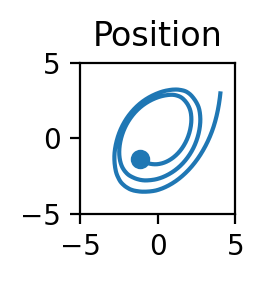

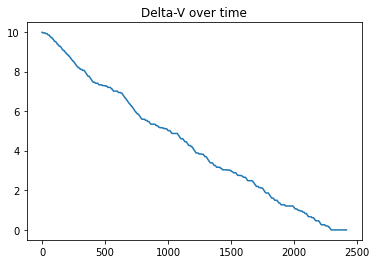

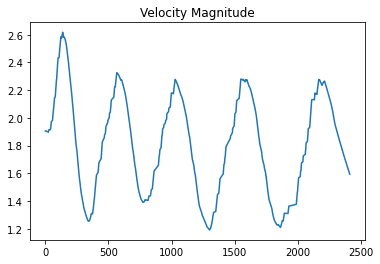

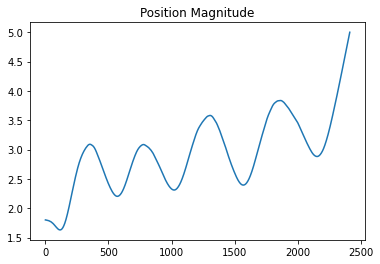

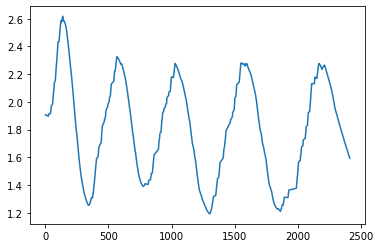

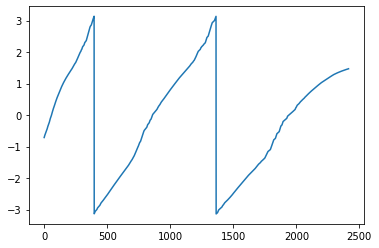

In [630]:

plot_policy(Q_qlearning)

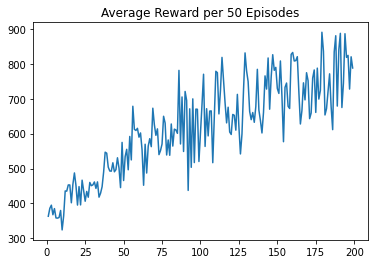

In [632]:
    
def plot_result():
    plt.plot(np.arange(1, len(qlearning_result)), qlearning_result[1:])
    plt.title("Average Reward per 50 Episodes")
    plt.show()
    
plot_result()

-1.0
1.9999181158834742


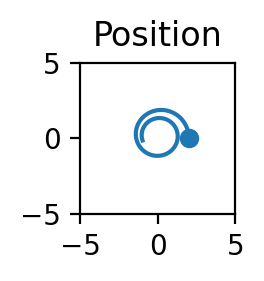

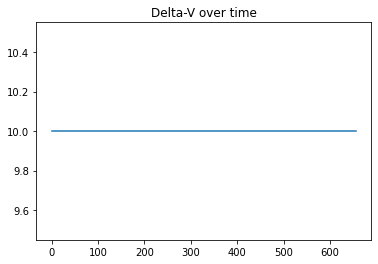

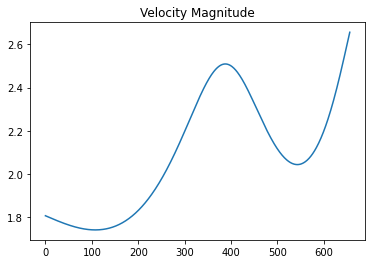

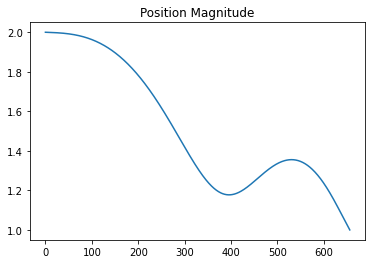

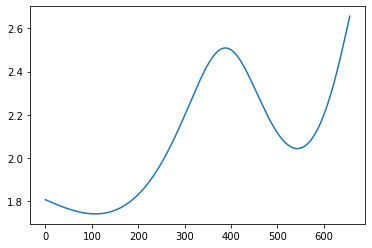

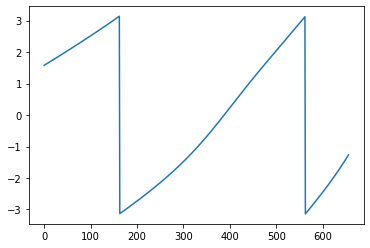

In [639]:
# plot baseline
orbitEnv = OrbitSimEnv(random_angle=False, random_distance=False)
plot_policy(Q_qlearning)

In [640]:
First_pass_q_learning = np.copy(Q_qlearning)
First_pass_q_result = np.copy(qlearning_result)

In [642]:
bins_distance = np.linspace(0,5,50) # state for each 0.1 distance
bins_theta = np.linspace(-np.pi,np.pi, 90) # state for every 4 degrees
bins_vel_mag = np.linspace(1,4,60) # 0.05
bins_vel_angle = np.linspace(-np.pi,np.pi, 90) # +/- 45 degrees from tangent to acceleration
bins_delta_v = np.linspace(0, 10, 50) # 0.1 

bins_vel_x = np.linspace(-3,3,30)
bins_vel_y = np.linspace(-3,3,30)

dobs_q = DiscretObs([bins_distance,bins_vel_mag,bins_vel_angle]) #bins_delta_v, bins_theta bins_delta_v, bins_vel_mag, bins_vel_angle, bins_vel_mag,bins_vel_angle

orbitEnv = OrbitSimEnv(random_angle=True, random_distance=True, random_distance_min_max=[11,49])

Q_qlearning = set_Q_qlearning(dobs_q.get_state_num_total(), 2)
q_learning_algo(dobs_q, orbitEnv, gamma=0.98, episode_count=50000)
ql_Q_98_50000 = np.copy(Q_qlearning)
ql_result_98_50000 = np.copy(qlearning_result)

Running Q-Learning Algorithm with gamma=0.98, alpha=None, epsilon=None, ep_count=50000, report_step=50
Step 0/1000	Reward: 0.0	Alpha:1.0	Epsilon:1.0
Step 1/1000	Reward: 158.36	Alpha:1.0	Epsilon:1.0
Step 2/1000	Reward: 212.24	Alpha:1.0	Epsilon:1.0
Step 3/1000	Reward: 126.64	Alpha:1.0	Epsilon:1.0
Step 4/1000	Reward: 175.5	Alpha:0.9978339382434924	Epsilon:1.0
Step 5/1000	Reward: 220.2	Alpha:0.9013562741829431	Epsilon:1.0
Step 6/1000	Reward: 179.5	Alpha:0.8224635000701379	Epsilon:0.998554759125819
Step 7/1000	Reward: 162.78	Alpha:0.7557228791981572	Epsilon:0.9318141382538384
Step 8/1000	Reward: 196.22	Alpha:0.7	Epsilon:0.8739768820994801
Step 9/1000	Reward: 139.52	Alpha:0.7	Epsilon:0.8229447128417019
Step 34/1000	Reward: 257.6	Alpha:0.7	Epsilon:0.24641694110709345
Step 35/1000	Reward: 202.42	Alpha:0.7	Epsilon:0.23383510863621626
Step 36/1000	Reward: 152.76	Alpha:0.7	Epsilon:0.2216075419001291
Step 37/1000	Reward: 166.06	Alpha:0.7	Epsilon:0.20971483596675833
Step 38/1000	Reward: 195.28	Alph

2780.0
1.1997688888303473


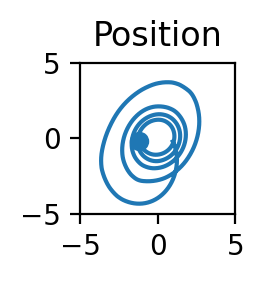

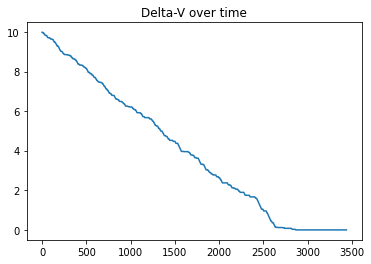

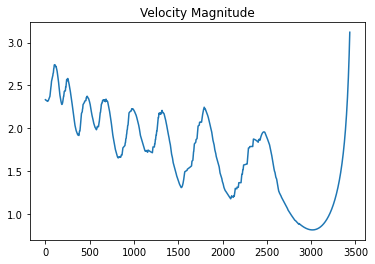

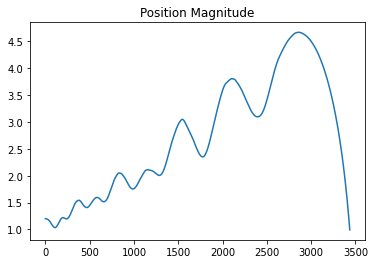

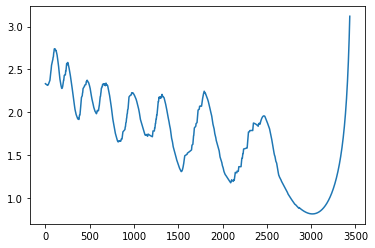

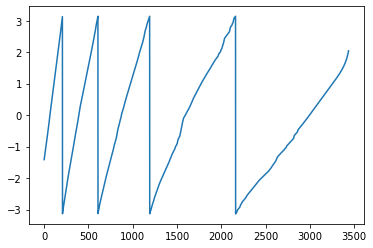

In [652]:
plot_policy(ql_Q_98_50000)


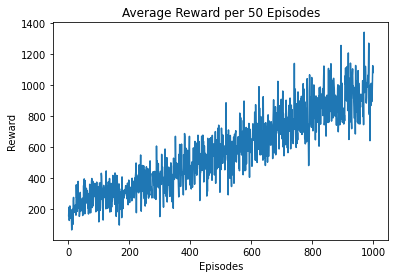

In [670]:
def plot_result():
    plt.plot(np.arange(1, len(qlearning_result)), qlearning_result[1:])
    plt.title("Average Reward per 50 Episodes")
    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.show()
    
plot_result()

2385.0
2.4999475816055776


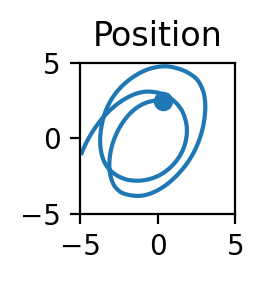

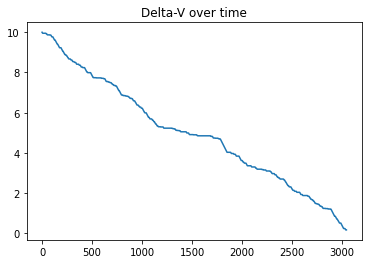

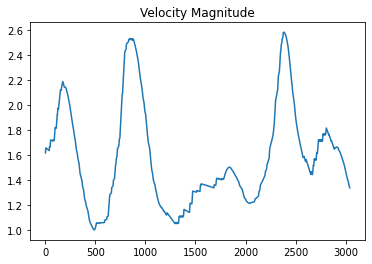

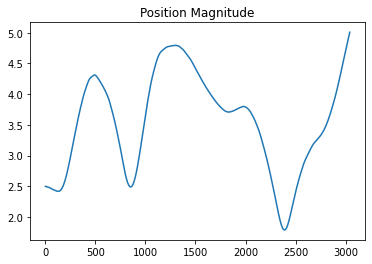

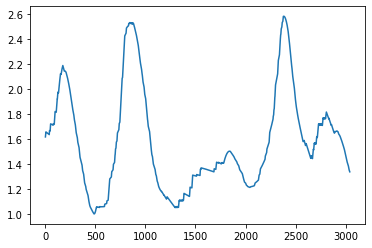

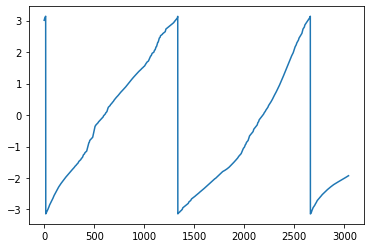

In [668]:
plot_policy(ql_Q_98_50000)